In [1]:
#text file handling and text processing
import pandas as pd
import numpy as np
import re 
import nltk
from nltk.corpus import stopwords
from numpy import array

#turn text->token id 
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#to create layers of the model, apply activation functions, create dense and dropout layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, GlobalMaxPooling1D, Embedding, LSTM, Conv1D

#divide dataset into train and test sets, and evaluate model performance
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, accuracy_score

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [10]:
#load dataset
df = pd.read_csv('IMDB_Dataset.csv', names=['Review', 'Sentiment'], skiprows=1)
print("\n Sample of Raw Dataset:\n")
print(df.sample(10).to_string(index=False))
df = df[['Review', 'Sentiment']].dropna()


 Sample of Raw Dataset:

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [3]:
df['Sentiment'] = df['Sentiment'].astype(str).str.strip().str.capitalize()

#remove anyhting that is not positve or negstive
df = df[df['Sentiment'].isin(['Positive', 'Negative'])]

# Update texts AFTER cleaning df
texts = df['Review'].astype(str).values

# Encode labels
labels = df['Sentiment'].map({'Positive': 1, 'Negative': 0}).astype(int).values


# Tokenize and Pad
vocab_size = 50000
maxlen = 500
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=maxlen)

# Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42)

print("\nSample Preprocessed Data for LSTM Model:\n")

# Display first 9 examples
for i in range(9):
    print(f"Review {i+1}:")
    print(f"Original Text: {texts[i][:150]}")
    print(f"Tokenized Sequence (first 10 tokens): {sequences[i][:10]}")
    print(f"Padded Sequence (first 10 values):    {padded[i][:10]}")

    if labels[i] == 1:
        sentiment = "Positive"
    else:
        sentiment = "Negative"

    print(f"Label (Encoded): {labels[i]} ({sentiment})")
    print("-" * 80)            



Sample Preprocessed Data for LSTM Model:

Review 1:
Original Text: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with
Tokenized Sequence (first 10 tokens): [28, 5, 2, 80, 2103, 46, 1073, 13, 101, 148]
Padded Sequence (first 10 values):    [0 0 0 0 0 0 0 0 0 0]
Label (Encoded): 1 (Positive)
--------------------------------------------------------------------------------
Review 2:
Original Text: A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes d
Tokenized Sequence (first 10 tokens): [4, 394, 121, 354, 8, 8, 2, 1386, 2978, 7]
Padded Sequence (first 10 values):    [0 0 0 0 0 0 0 0 0 0]
Label (Encoded): 1 (Positive)
--------------------------------------------------------------------------------
Review 3:
Original Text: I thought this was a wonderful way to spend time on a too hot summer weeke

In [4]:
model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=maxlen))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, maxlen))
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 500, 128)       │     6,400,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,449,473 (24.60 MB)

 Trainable params: 6,449,473 (24.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.2) 

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 318s 563ms/step - accuracy: 0.9847 - loss: 0.0470 - val_accuracy: 0.8485 - val_loss: 0.4365
Epoch 2/10
111/500 ━━━━━━━━━━━━━━━━━━━━ 3:24 526ms/step - accuracy: 0.9869 - loss: 0.0484

In [8]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.8819 - loss: 0.4248
Test Accuracy: 88.19%


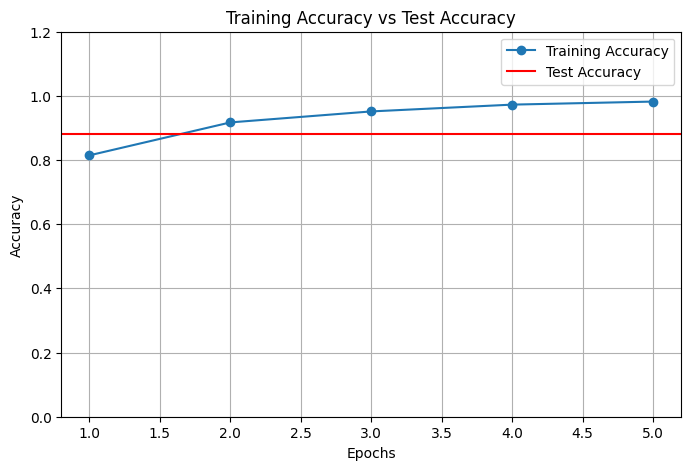

In [7]:
import matplotlib.pyplot as plt        

train_acc = history.history['accuracy']        # list of accuracy per epoch
test_acc = accuracy                            # final test accuracy

epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(8,5))

# Training accuracy line
plt.plot(epochs, train_acc, marker='o', label='Training Accuracy')

# Test accuracy horizontal line
plt.axhline(y=test_acc, color='red', linestyle='-', label='Test Accuracy')

plt.title("Training Accuracy vs Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0, 1.2)

plt.legend()
plt.grid(True)
plt.show()
